In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

In [5]:
import numpy as np

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features
y = abalone.data.targets

#X = pd.get_dummies(X, columns=['Sex'])
X = X.drop(columns=['Sex'])

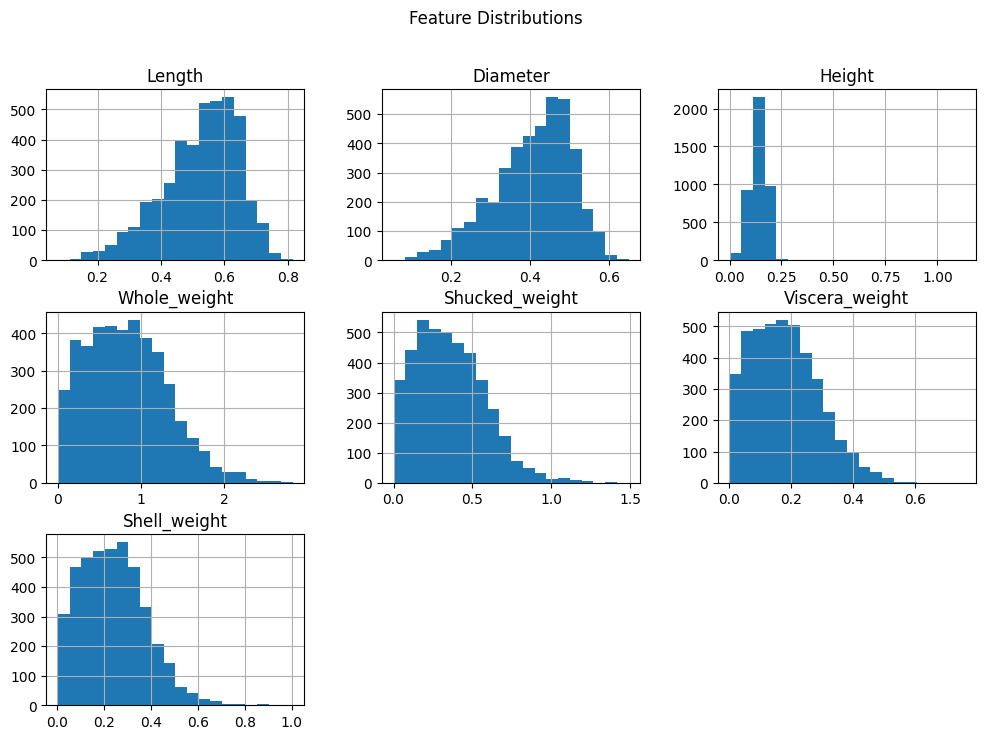

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

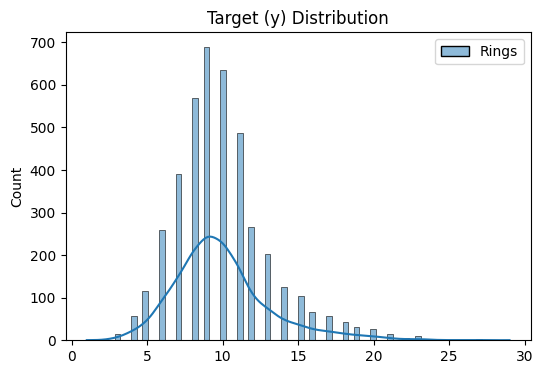

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

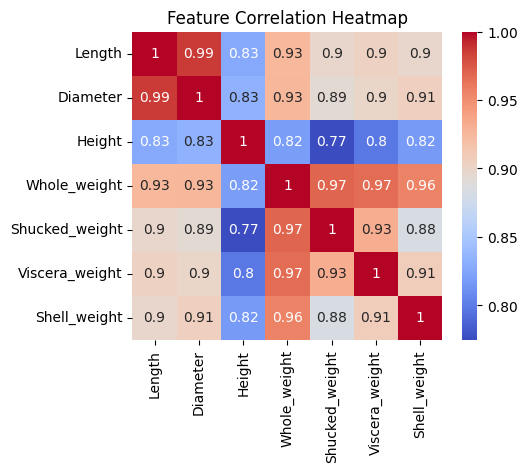

In [8]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [9]:
X = X.values.astype(float)
y = np.array(y).astype(np.float32).reshape(-1)

In [10]:
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (all 4):")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix (all 4):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.146306                 1.084424             1.106866   
1                  1.117778                 1.052268             1.054285   
2                  1.104121                 1.121633             1.222908   
3                  1.041576                 1.096341             1.106131   
4                  1.045333                 1.065918             1.102174   
5                  1.088155                 1.157808             1.147531   
6                  1.176737                 1.109870             1.103103   
7                  1.104229                 1.024481             1.082664   
8                  1.057534                 1.036935             1.128508   
9                  1.258045                 1.033385             1.188549   
mean               1.113981                 1.078306             1.124272   
std                0.066460      

In [11]:
rhat_df.to_csv("results4/real1_Abalone_rhat.csv", index=False)

In [12]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
rhat_df2 = comparison.gelman_rubin_r_compare(X, y, n_runs=10, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, 
                                            proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default,
                                            n_jobs=-2)
mean_row = pd.DataFrame([rhat_df2.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df2.std()], index=["std"])
rhat_df2_with_stats = pd.concat([rhat_df2, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix (only 2):")
print(rhat_df2_with_stats)

Gelman-Rubin R̂ comparison matrix (only 2):
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.030160                 1.042024             1.221127   
1                  1.112179                 1.019533             1.139589   
2                  1.058510                 1.029519             1.080422   
3                  1.060545                 1.075416             1.085224   
4                  1.107453                 1.074350             1.259158   
5                  1.105102                 1.075037             1.110714   
6                  1.167486                 1.075635             1.131829   
7                  1.093966                 1.070509             1.155172   
8                  1.049655                 1.167870             1.098841   
9                  1.055253                 1.116204             1.339232   
mean               1.084031                 1.074610             1.162131   
std                0.040775     

In [13]:
rhat_df2.to_csv("results2/real1_Abalone_rhat.csv", index=False)

In [14]:
# Create comparison table with means and standard deviations in parentheses
comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])

# Calculate mean and standard deviation for each column
for col in rhat_df.columns:
    # First row: All 4 operations (grow/prune/change/swap)
    mean_4ops = rhat_df[col].mean()
    std_4ops = rhat_df[col].std()
    comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Second row: Only grow/prune operations
    mean_2ops = rhat_df2[col].mean()
    std_2ops = rhat_df2[col].std()
    comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"

print("Gelman-Rubin R̂ Comparison Table:")
print(comparison_table)

Gelman-Rubin R̂ Comparison Table:
                 MultiBART_Rhat_Sigma2 DefaultBART_Rhat_Sigma2  \
All 4 Operations       1.1140 (0.0665)         1.0783 (0.0435)   
Grow/Prune Only        1.0840 (0.0408)         1.0746 (0.0429)   

                 MultiBART_Rhat_RMSE DefaultBART_Rhat_RMSE  
All 4 Operations     1.1243 (0.0501)       1.2364 (0.0851)  
Grow/Prune Only      1.1621 (0.0850)       1.3175 (0.1113)  


In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

proposal_probs_mtmh={"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
proposal_probs_default={"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      4.950381  4.988469
1      4.742502  4.739308
2      5.274147  5.375862
3      4.559035  4.597135
4      4.458468  4.429484
5      5.140734  5.077842
6      5.165872  5.149329
7      5.326703  5.274694
8      5.146579  5.007960
9      5.265561  5.253102
mean   5.002998  4.989319
std    0.312268  0.309830

pi_length:
      bart_mtmh      bart
0      8.037198  8.082582
1      7.966057  8.213273
2      7.849606  7.958014
3      8.075064  8.108954
4      8.216996  8.293825
5      7.869564  7.985721
6      7.959084  8.028397
7      7.869422  7.955359
8      7.903904  8.048337
9      7.900066  7.960645
mean   7.964696  8.063511
std    0.115649  0.114903

coverage:
      bart_mtmh      bart
0      0.933971  0.933971
1      0.933014  0.931100
2      0.922488  0.925359
3      0.934928  0.931100
4      0.942584  0.938756
5      0.926316  0.924402
6      0.916746  0.913876
7      0.913876  0.915789
8      0.928230  0.940670
9      0.934928  0.928230
mean 

In [11]:
for k, v in mse_results.items():
    csv_name = f"results4/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

In [12]:
proposal_probs_mtmh={"multi_grow": 0.5, "multi_prune": 0.5}
proposal_probs_default={"grow": 0.5, "prune": 0.5}
mse_results2 = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5,
                                             proposal_probs_mtmh=proposal_probs_mtmh, proposal_probs_default=proposal_probs_default)
for k, v in mse_results2.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")

test_mse:
      bart_mtmh      bart
0      4.841730  4.895236
1      4.734074  4.735313
2      5.383014  5.349640
3      4.600672  4.562785
4      4.545672  4.349667
5      5.227411  5.114158
6      5.062936  4.985995
7      5.356830  5.258909
8      4.953412  5.098315
9      5.235461  5.181944
mean   4.994121  4.953196
std    0.307067  0.319461

pi_length:
      bart_mtmh      bart
0      8.104701  8.084736
1      8.122704  8.196730
2      7.938733  8.005212
3      8.044497  8.262925
4      8.205113  8.300877
5      7.805132  8.053108
6      8.012582  8.145676
7      7.985364  7.880138
8      7.959768  8.074396
9      7.927622  8.038782
mean   8.010622  8.104258
std    0.114454  0.125750

coverage:
      bart_mtmh      bart
0      0.935885  0.929187
1      0.932057  0.931100
2      0.926316  0.927273
3      0.933971  0.937799
4      0.935885  0.941627
5      0.915789  0.921531
6      0.922488  0.922488
7      0.917703  0.919617
8      0.938756  0.936842
9      0.928230  0.934928
mean 

In [13]:
for k, v in mse_results2.items():
    csv_name = f"results2/real1_Abalone_{k}.csv"
    v.to_csv(csv_name, index=False)

In [14]:
# Create comparison tables for all MSE results metrics
for metric_name, metric_df in mse_results.items():
    print(f"\n{metric_name.upper()} Comparison Table:")
    print("=" * 50)
    
    # Create comparison table for this metric
    comparison_table = pd.DataFrame(index=['All 4 Operations', 'Grow/Prune Only'])
    
    # Calculate mean and standard deviation for each column
    for col in metric_df.columns:
        # First row: All 4 operations (grow/prune/change/swap)
        mean_4ops = metric_df[col].mean()
        std_4ops = metric_df[col].std()
        comparison_table.loc['All 4 Operations', col] = f"{mean_4ops:.4f} ({std_4ops:.4f})"
    
    # Get corresponding metric from the 2-operations results
    metric_df2 = mse_results2[metric_name]
    for col in metric_df2.columns:
        # Second row: Only grow/prune operations
        mean_2ops = metric_df2[col].mean()
        std_2ops = metric_df2[col].std()
        comparison_table.loc['Grow/Prune Only', col] = f"{mean_2ops:.4f} ({std_2ops:.4f})"
    
    print(comparison_table)
    print()


TEST_MSE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  5.0030 (0.3123)  4.9893 (0.3098)
Grow/Prune Only   4.9941 (0.3071)  4.9532 (0.3195)


PI_LENGTH Comparison Table:
                        bart_mtmh             bart
All 4 Operations  7.9647 (0.1156)  8.0635 (0.1149)
Grow/Prune Only   8.0106 (0.1145)  8.1043 (0.1257)


COVERAGE Comparison Table:
                        bart_mtmh             bart
All 4 Operations  0.9287 (0.0090)  0.9283 (0.0088)
Grow/Prune Only   0.9287 (0.0080)  0.9302 (0.0075)


TRAIN_TIME Comparison Table:
                          bart_mtmh              bart
All 4 Operations  168.8166 (4.8574)  24.4511 (1.3210)
Grow/Prune Only   109.6950 (2.6810)  25.3401 (0.9688)

